>### 10.3_순환 신경망 이해하기
- 밀집 연결 모델, 컨브넷처럼 모든 신경망의 특징은 메모리가 없다.
- 네트워크에 주입되는 입력은 개별적으로 처리되며 입력 간에 유지되는 상태가 없다.
- 그렇기에 시계열 데이터 포인트를 처리하려면 네트워크에 전체 시퀀스를 주입해야 한다.
    - 즉 5일치 데이터를 펼쳐서 하나의 큰 벡터로 만들어서 처리(피드포워드 네트워크) 

>### 10.3.1_케라스의 순환 층
- 어떤 길이의 시퀀스도 처리할 수 있는 RNN(sharp 매개변수에 timesteps 항목에 None으로 지정)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

print(outputs.shape)

(None, 16)


>### 케라스에 있는 모든 순환 층은 두가지 모드로 실행 가능(return_sequences 매개변수로 제어 가능)
- 각 타임스템의 출력을 모은 전체 시퀀스((batch_size, timesteps, output_features) 크기의 랭크-3 텐서)를 반환
- 입력 시퀀스의 마지막 출력((batch_size, output_features) 크기의 랭크-2 텐서)만 반환

>### 마지막 출력 스텝만 반환하는 RNN층

In [4]:
num_features = 14
steps = 20
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)

print(outputs.shape)

(None, 16)


>### 전체 출력 시퀸스 반환하는 RNN층

In [5]:
num_features = 14
steps = 20
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)

print(outputs.shape)

(None, 20, 16)


>### 스태킹 RNN층
- 네트워크 표현력 증가시키기 위해, 여러 개의 순환층을 차례로 쌓는 것이 유용할 때가 있음

In [6]:
num_features = 14
steps = 20
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

print(outputs.shape)

(None, 16)


>### 10.4_순환 신경망의 고급 사용법
- 순환 드롭아웃(recurrent dropout): 순환 층에서 과대적합을 방지하기 위해 사용
- 스태킹 순환층(stacking recurrent layer): 모델의 표현 능력 증가(그 대신, 계산 비용이 많이 든다.)
- 양방향 순환층(bidirectional recurrent layer): 순환 네트워크에 같은 정보를 다른 방햐응로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지

>### 1) 순환 드롭 아웃 사용하기
- 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해된다.
- 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라, 동일한 패턴으로 유닛을 드롭아웃한다. --> 모든 타임스텝에 적용

In [4]:
## data load
import os

fname = os.path.join("./jena_data/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")

lines = lines[1:]

print(header)
print(len(header))
print(len(lines))


## data preprocess
import numpy as np

temperature = np.zeros(len(lines),)
print("온도 데이터 array:", temperature.shape)

raw_data = np.zeros((len(lines), len(header) - 1)) ## Date Time 열 제외하기 위해(14개 데이터만 사용)
print("미래 온도를 예측하기 위해 사용할 feature:",raw_data.shape)

for i, line in enumerate(lines):
    values = list(float(x) for x in line.split(",")[1:]) ## 첫번째 열[Date Time]을 빼고 전달.
    temperature[i] = values[1]   ## temperature 배열 저장
    raw_data[i, :] = values[:]   ## 온도 포함하여 모든 열을 저장 


## data: train, val, test
train_cnt = int(len(temperature)*0.5)
print(train_cnt)

val_cnt = int(len(temperature)*0.25)
print(val_cnt)

test_cnt = len(temperature) - train_cnt - val_cnt
print(test_cnt)

print("Total count:", train_cnt + val_cnt + test_cnt)



## 데이터 정규화
mean = raw_data[:train_cnt].mean(axis=0)
raw_data = raw_data - mean

std = raw_data[:train_cnt].std(axis=0)
raw_data = raw_data / std



sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1) ## 시퀸스 끝에서 24시간 후의 온도 

batch_size = 256

import keras

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = train_cnt)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = train_cnt,
    end_index = train_cnt + val_cnt)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = train_cnt + val_cnt)  

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420451
온도 데이터 array: (420451,)
미래 온도를 예측하기 위해 사용할 feature: (420451, 14)
210225
105112
105114
Total count: 420451


In [2]:
## 결과 그래프 그리기
import matplotlib.pyplot as plt

def plot(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


def model_fn(a_layer=None):
    model = Sequential(name='LSTM_model')
    
    # 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
    # x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
    
    model.add(layers.LSTM(32, input_shape=(sequence_length, raw_data.shape[-1])))
    model.add(layers.Dropout(0.5))
    
    if a_layer:
        model.add(a_layer)
    
    model.add(layers.Dense(1))

    return model


model = model_fn()
model.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_LSTM.keras',
                                    save_best_only=True)
]

history_LSTM = model.fit(train_dataset,
                        epochs=50, 
                        validation_data=val_dataset,
                        callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 26s 27ms/step - loss: 83.8245 - mae: 7.2835 - val_loss: 49.3236 - val_mae: 5.5890
Epoch 2/50
819/819 [==============================] - 22s 26ms/step - loss: 56.2466 - mae: 5.8425 - val_loss: 33.5490 - val_mae: 4.4553
Epoch 3/50
819/819 [==============================] - 22s 26ms/step - loss: 45.2586 - mae: 5.1907 - val_loss: 28.2981 - val_mae: 4.1385
Epoch 4/50
819/819 [==============================] - 22s 26ms/step - loss: 40.2434 - mae: 4.8747 - val_loss: 22.6138 - val_mae: 3.6664
Epoch 5/50
819/819 [==============================] - 22s 26ms/step - loss: 38.2854 - mae: 4.7503 - val_loss: 20.8599 - val_mae: 3.5240
Epoch 6/50
819/819 [==============================] - 22s 26ms/step - loss: 37.7648 - mae: 4.7176 - val_loss: 19.4714 - val_mae: 3.4168
Epoch 7/50
819/819 [==============================] - 22s 26ms/step - loss: 37.2810 - mae: 4.6901 - val_loss: 20.8054 - val_mae: 3.5804
Epoch 8/50
819/819 [============================

In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


def model_fn(a_layer=None):
    model = Sequential(name='GRU_model')
    
    # 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
    # x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
    # x = layers.GRU(32, recurrent_dropout=0.5)(x)
    model.add(layers.GRU(32, return_sequences=True, input_shape=(sequence_length, raw_data.shape[-1])))
    model.add(layers.GRU(32))
    model.add(layers.Dropout(0.5))
    
    if a_layer:
        model.add(a_layer)
    
    model.add(layers.Dense(1))

    return model


model = model_fn()
model.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_GRU.keras',
                                    save_best_only=True)
]

history_GRU = model.fit(train_dataset,
                        epochs=50, 
                        validation_data=val_dataset,
                        callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 35s 38ms/step - loss: 35.0389 - mae: 4.5488 - val_loss: 16.6598 - val_mae: 3.1950
Epoch 2/50
819/819 [==============================] - 30s 36ms/step - loss: 22.0604 - mae: 3.6991 - val_loss: 23.1430 - val_mae: 3.8876
Epoch 3/50
819/819 [==============================] - 30s 37ms/step - loss: 20.8572 - mae: 3.5839 - val_loss: 18.5082 - val_mae: 3.3975
Epoch 4/50
819/819 [==============================] - 30s 36ms/step - loss: 20.0349 - mae: 3.5082 - val_loss: 19.0231 - val_mae: 3.4551
Epoch 5/50
819/819 [==============================] - 30s 36ms/step - loss: 19.3348 - mae: 3.4460 - val_loss: 15.3931 - val_mae: 3.0671
Epoch 6/50
819/819 [==============================] - 30s 36ms/step - loss: 18.7533 - mae: 3.3894 - val_loss: 17.4270 - val_mae: 3.3059
Epoch 7/50
819/819 [==============================] - 30s 36ms/step - loss: 18.2540 - mae: 3.3460 - val_loss: 13.5868 - val_mae: 2.8974
Epoch 8/50
819/819 [============================

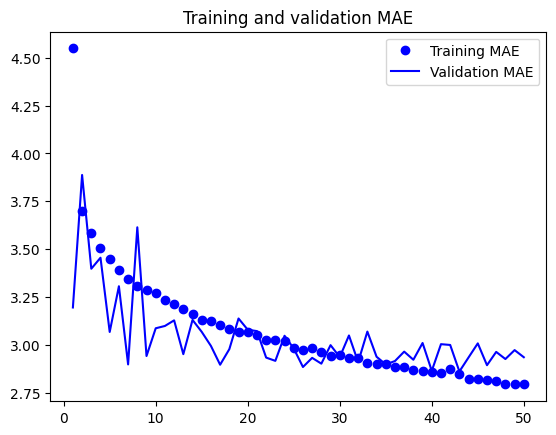

In [6]:
plot(history_GRU)

In [1]:
import tensorflow as tf

# GPU를 사용하고 있는지 확인
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU가 발견되지 않음. CPU를 사용합니다.")

# TensorFlow 버전 확인
print("TensorFlow 버전: {}".format(tf.__version__))

Default GPU Device: /device:GPU:0
TensorFlow 버전: 2.10.0
